## A New Version of WSD with Management word pre-specified




Transformer based Word Sense Disambiguation
- fine-tune bert base model to distinguish two senses of management
    - sense 1: to handle, supervise, control
    - sense 2: to cope, to succeed in obtaining or creating


- Code is based on ChatGPT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -U accelerate
! pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 64.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.45.2', '1.0.1')

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, AdamW
from torch.nn import CrossEntropyLoss

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import torch.nn.functional as F
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Load and Prepare Dataset

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizerFast
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import re
import numpy as np

In [ ]:
class ManageDataset(Dataset):
    def __init__(self, tokenizer, sentences, labels, target_char_spans):
        self.tokenizer = tokenizer
        self.sentences = sentences
        self.labels = labels
        self.char_spans = target_char_spans

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        # Tokenize the sentence into BERT tokens with offset mappings (fast tokenizer)
        inputs = self.tokenizer(
            self.sentences[idx],
            return_tensors="pt",
            truncation=True,
            padding='max_length',
            max_length=256,
            return_offsets_mapping=True # return tuple indicating the sub-token's start position
        )

        # Generate the manag_mask
        manag_mask = self._get_manag_mask(
            self.sentences[idx],
            inputs["input_ids"][0],
            inputs["offset_mapping"][0],
            self.char_spans[idx]
        )

        # Return tokens' embeddings and the label
        return {
            "input_ids": inputs["input_ids"][0],
            "attention_mask": inputs["attention_mask"][0],
            "manag_mask": manag_mask,
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def _get_manag_mask(self, sentence, input_ids, offset_mapping, target_char_span):
        # Initialize manag_mask
        manag_mask = torch.zeros_like(input_ids, dtype=torch.bool)
        # Iterate over BERT tokens and align with target word's character span
        for i, (start, end) in enumerate(offset_mapping):
            if start == 0 and end == 0:
                continue  # Skip special tokens like [CLS], [SEP], [PAD]
            if (start >= target_char_span[0] and start < target_char_span[1]) or \
               (end > target_char_span[0] and end <= target_char_span[1]) or \
               (start <= target_char_span[0] and end >= target_char_span[1]):
                manag_mask[i] = True
        return manag_mask

# Modify the Trainer Architecture

In [ ]:
import torch.nn as nn
from transformers import BertModel, BertTokenizerFast, AdamW
import os
import json

In [ ]:
class BERTWSDModel(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_labels=2):
        super(BERTWSDModel, self).__init__()
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        # Classification head
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.3)
        # Save the configuration
        self.config = self.bert.config
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, manag_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)

        # Apply manag_mask to get embeddings of target tokens
        manag_mask_expanded = manag_mask.unsqueeze(-1).expand(last_hidden_state.size())
        target_embeddings = last_hidden_state * manag_mask_expanded.float()

        # Compute average embeddings for each sample in the batch
        token_counts = manag_mask.sum(dim=1).unsqueeze(-1)  # (batch_size, 1)
        # Avoid division by zero
        token_counts[token_counts == 0] = 1
        avg_embeddings = target_embeddings.sum(dim=1) / token_counts  # (batch_size, hidden_size)

        # Apply dropout
        pooled_output = self.dropout(avg_embeddings)

        # Get logits from classifier
        logits = self.classifier(pooled_output)  # (batch_size, num_labels)

        return logits

    def save_pretrained(self, save_directory):
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        torch.save(self.state_dict(), os.path.join(save_directory, 'pytorch_model.bin'))
        self.config.save_pretrained(save_directory)
        print(f"Model saved to {save_directory}")

    @classmethod
    def from_pretrained(cls, load_directory):
        # Load the model configuration
        config = BertModel.from_pretrained(load_directory).config
        # Initialize the model
        model = cls(bert_model_name=load_directory)
        # Load the model state dict
        model_load_path = os.path.join(load_directory, 'pytorch_model.bin')
        if torch.cuda.is_available():
            model.load_state_dict(torch.load(model_load_path))
            model = model.to('cuda')
        else:
            model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))
        return model

# Train

In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

In [ ]:
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet, words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('words')
english_words = set(words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
# load dataset
data_directory = "./drive/Othercomputers/My MacBook Pro (1)/Project/Managament/data/wos/"
ds1 = pd.read_csv(data_directory + "benchmark_1000.csv")
ds2 = pd.read_csv(data_directory + "benchmark_1000_transOnly.csv") # a harder version
# combined df
ds_combined = pd.concat([ds1, ds2])

In [ ]:
# remove double quotations due to performance of nltk word tokenize
def replace_newlines(text):
    text = re.sub(r'-\n', '', text)
    text = re.sub(r'\n', ' ', text)
    return text

# remove double quotation marks
def remove_quotation(text):
    text = re.sub(r'\"', '', text)
    text = re.sub(r'\'{2}', '', text)
    return text

def text_cleaning(text):
    text = replace_newlines(text)
    text = remove_quotation(text)
    return text

def sent_length(sent):
    return len(sent.split(" "))

# check ocr quality
def ocr_quality_check(text):
    tokens = text.split(" ")
    non_english_count = sum(1 for token in tokens if token not in english_words)
    total_words = len(tokens)
    if total_words == 0:
        return 1
    non_english_ratio = non_english_count / total_words
    return non_english_ratio

def get_word_char_spans(sentence, words):
    char_spans = []
    current_pos = 0
    for word in words:
        pattern = re.escape(word)
        match = re.search(pattern, sentence[current_pos:])
        if match is None:
            raise ValueError(f"Word '{word}' not found in sentence.")
        start_idx = current_pos + match.start()
        end_idx = current_pos + match.end()
        char_spans.append((start_idx, end_idx))
        current_pos = end_idx
    return char_spans

def extract_mgmt_with_pos(sentence):
    # Tokenize and get POS tags
    words = word_tokenize(sentence)
    pos_tags = pos_tag(words)
    mgmt_word_loc = []
    char_spans = get_word_char_spans(sentence, words)

    for i in range(len(words)):
        word = words[i]
        tag = pos_tags[i]
        char_span = char_spans[i]
        if_intransitive = False
        if "manag" in word:
            # check if intransitve verb
            if "VB" in tag[1]:
                # check if the next word is to
                if i+1 < len(words) and words[i+1] == "to":
                    if_intransitive = True
            mgmt_word_loc.append((word, tag[1], char_span, if_intransitive))
    return mgmt_word_loc

In [ ]:
def df_processing(df):
    df['Sentence'] = df['Sentence'].apply(text_cleaning)
    df['sent_length'] = df['Sentence'].apply(sent_length)
    df['noneng_ratio'] = df['Sentence'].apply(ocr_quality_check)
    df = df[(df['sent_length'] >= 10) & (df['sent_length'] <= 100) & (df['noneng_ratio'] < 0.5)]
    df['mgmt_tag'] = df['Sentence'].apply(extract_mgmt_with_pos)
    df = df.explode('mgmt_tag')
    df['focal_word'] = df['mgmt_tag'].apply(lambda x: x[0])
    df['focal_pos'] = df['mgmt_tag'].apply(lambda x: x[1])
    df['focal_char_span'] = df['mgmt_tag'].apply(lambda x: x[2])
    df['if_intransitive'] = df['mgmt_tag'].apply(lambda x: x[3])
    df.drop(columns=['mgmt_tag'], inplace=True)
    df = df.reset_index(drop=True)
    return df

In [ ]:
df_combined = df_processing(ds_combined)

<ipython-input-18-6004d4d1efb6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mgmt_tag'] = df['Sentence'].apply(extract_mgmt_with_pos)


In [ ]:
# split train and val set
def train_val_split(df, val_size=0.1):
    sentences = df["Sentence"].tolist()
    original_labels = df["manage_sense_gpt4"].tolist()
    label_map = {'A': 1, 'B': 0}
    numerical_labels = [label_map[label] for label in original_labels]
    target_char_spans = list(df['focal_char_span'])
    train_sentences, val_sentences, train_labels, val_labels, train_char_spans, val_char_spans = train_test_split(
        sentences, numerical_labels, target_char_spans, test_size=val_size, random_state=42
    )
    return train_sentences, val_sentences, train_labels, val_labels, train_char_spans, val_char_spans

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
df_combined = df_processing(ds_combined)
train_sentences, val_sentences, train_labels, val_labels, train_char_spans, val_char_spans = train_val_split(ds_combined)
train_dataset = ManageDataset(tokenizer, train_sentences, train_labels, train_char_spans)
val_dataset = ManageDataset(tokenizer, val_sentences, val_labels, val_char_spans)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Initialize the model
model = BERTWSDModel(num_labels=2)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

# Number of training epochs
epochs = 1

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        manag_mask = batch['manag_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, manag_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    total_val_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            manag_mask = batch['manag_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, manag_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_predictions.double() / len(val_dataset)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1, Training Loss: 0.2408
Validation Loss: 0.1687, Accuracy: 0.9524


In [ ]:
save_directory = "./drive/Othercomputers/My MacBook Pro (1)/Project/Managament/data/BERT/WSD_Oct21/"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Model saved to ./drive/Othercomputers/My MacBook Pro (1)/Project/Managament/data/BERT/WSD_Oct21/


('./drive/Othercomputers/My MacBook Pro (1)/Project/Managament/data/BERT/WSD_Oct21/tokenizer_config.json',
 './drive/Othercomputers/My MacBook Pro (1)/Project/Managament/data/BERT/WSD_Oct21/special_tokens_map.json',
 './drive/Othercomputers/My MacBook Pro (1)/Project/Managament/data/BERT/WSD_Oct21/vocab.txt',
 './drive/Othercomputers/My MacBook Pro (1)/Project/Managament/data/BERT/WSD_Oct21/added_tokens.json',
 './drive/Othercomputers/My MacBook Pro (1)/Project/Managament/data/BERT/WSD_Oct21/tokenizer.json')

# Inference

In [ ]:
save_directory = "./drive/Othercomputers/My MacBook Pro (1)/Project/Managament/data/BERT/WSD_Oct21/"
# load model from saved file, no need to mount on GPU
model = BERTWSDModel.from_pretrained(save_directory)
tokenizer = BertTokenizerFast.from_pretrained(save_directory)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

<ipython-input-9-2010852c4b9c>:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))


BERTWSDModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
def infer(sentences, char_spans, model, tokenizer):
    dataset = ManageDataset(tokenizer, sentences, [0]*len(sentences), char_spans)  # Dummy labels just for data processing
    loader = DataLoader(dataset, batch_size=150)  # Set batch size according to your needs

    model.eval()
    pred_labels = []
    confidences = []  # To store prediction confidences

    with torch.no_grad():
        for batch in tqdm(loader, desc="Inferencing", unit="batch"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            manag_mask = batch["manag_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask, manag_mask)

            # Convert logits to probabilities using softmax
            probs = F.softmax(logits, dim=1)

            # Get the predicted labels and their corresponding confidences
            preds = torch.argmax(logits, dim=1)
            conf = probs[range(probs.shape[0]), preds].tolist()  # Get the confidence of the predicted class for each sample

            pred_labels.extend(preds.tolist())
            confidences.extend(conf)

    return pred_labels, confidences  # Return both predicted labels and their confidences

In [ ]:
# individual prediction
sentence = "The female manager of the team manages to persuade the top management team on the next project."
char_span = get_word_char_spans(sentence, ["manager","manages","management"])[2]
infer([sentence],[char_span],model, tokenizer)

Inferencing: 100%|██████████| 1/1 [00:00<00:00, 28.22batch/s]


([1], [0.9601778388023376])

## A more systematic test

In [ ]:
data_directory = "./drive/Othercomputers/My MacBook Pro (1)/Project/Managament/data/wos/"

test_df = pd.read_csv(data_directory + "finetune_ds_balanced_stratified.csv")
test_df.rename(columns={'sentence': 'Sentence'}, inplace=True)
test_df = df_processing(test_df)
sentences = test_df["Sentence"].tolist()
true_labels = test_df["Manage_Sense"].tolist()
char_spans = list(test_df['focal_char_span'])

<ipython-input-28-6004d4d1efb6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mgmt_tag'] = df['Sentence'].apply(extract_mgmt_with_pos)


In [ ]:
pred_labels, confidences = infer(sentences, char_spans, model, tokenizer)

Inferencing: 100%|██████████| 1/1 [00:01<00:00,  1.75s/batch]


In [ ]:
# # Evaluation, same from the 1NN method
def calculate_performance_metrics(y_true, y_pred):
    """
    Calculates False Positive, False Negative, and F1 Score for binary classification with 'A' and 'B' labels.
    y_true: List of actual labels ('A' or 'B')
    y_pred: List of predicted labels ('A' or 'B')
    """

    # Initialize the counts for TP, FP, FN, and TN to zero.
    TP = FP = FN = TN = 0

    # Count the occurrences of TP, FP, FN, and TN
    for true, pred in zip(y_true, y_pred):
        if true == 'A' and pred == 'A':
            TP += 1
        elif true == 'B' and pred == 'A':
            FP += 1
        elif true == 'A' and pred == 'B':
            FN += 1
        elif true == 'B' and pred == 'B':
            TN += 1

    # Calculate precision and recall
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return f1_score, FP, FN, precision, recall

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=['A','B'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A','B'])
    disp.plot()

In [ ]:
label_map_rev = {1: "A", 0: "B"}
alpha_labels = [label_map_rev[label] for label in pred_labels]
f1, fp, fn, precision, recall=calculate_performance_metrics(true_labels, alpha_labels)
print(f"F1 Score: {f1}, False Positives (B predicted as A): {fp}, False Negatives (A predicted as B): {fn},\nPrecision: {precision}, Recall: {recall}")

F1 Score: 0.9620253164556963, False Positives (B predicted as A): 3, False Negatives (A predicted as B): 0,
Precision: 0.926829268292683, Recall: 1.0


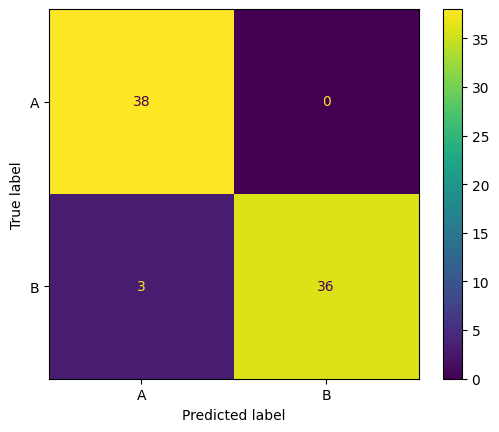

In [ ]:
plot_confusion_matrix(true_labels, alpha_labels)

In [ ]:
# optional: print the error prediction + sentence
def print_error_predictions(y_true, y_pred, sentences):
    FP_prediction = []
    FN_prediction = []
    for i in range(len(sentences)):
        true = y_true[i]
        pred = y_pred[i]
        if true == 'A' and pred == 'B':
            FN_prediction.append([true, pred, sentences[i]])
        elif true == 'B' and pred == 'A':
            FP_prediction.append([true, pred, sentences[i]])
    return FP_prediction, FN_prediction

In [ ]:
FP_prediction, FN_prediction = print_error_predictions(true_labels, alpha_labels, sentences)
print(f"False Positives:")
for pred in FP_prediction:
    print(pred)
print(f"False Negatives:")
for pred in FN_prediction:
    print(pred)

False Positives:
['B', 'A', "Only the single American in the cast, Austin Pendleton, as the stammering Irving, found the play's native idiom, wisely electing the life of the role even if he couldn't manage the accent."]
['B', 'A', 'For most people, managing personal finances usually falls in the category of dog awful.']
['B', 'A', 'During the first year twins often have to manage with less ‘mothering’ than other babies.']
False Negatives:
